# Connecticut Redistricting Analysis: Data Wrangling

- Project Objective: Analyze final 2021 CT State House and State Senate maps relative to incumbent protection
- Notebook Objective: Collect and organize all available public data necessary for GerryChain analysis

## Data Source

The main source of data for this project located on the Connecticut General Assembly website on their [2021 Redistricting Project](https://www.cga.ct.gov/rr/taskforce.asp?TF=20210401_2021%20Redistricting%20Project) committee page. 

- [Geographic Data](https://www.cga.ct.gov/rr/tfs/20210401_2021%20Redistricting%20Project/data.asp)
- [Election Data](https://www.cga.ct.gov/rr/tfs/20210401_2021%20Redistricting%20Project/data.asp)
- [Incumbent Data](https://www.cga.ct.gov/rr/tfs/20210401_2021%20Redistricting%20Project/data.asp)
- [2021 Final House Map](https://www.cga.ct.gov/rr/tfs/20210401_2021%20Redistricting%20Project/hmaps.asp)
- [2021 Final Senate Map](https://www.cga.ct.gov/rr/tfs/20210401_2021%20Redistricting%20Project/hmaps.asp)

The 2020 U.S. Census data for the voting aged population (VAP) at the census block level was downloaded from [Connecticut Open Data](https://data.ct.gov/Government/2020-U-S-Census-Block-Adjustments/bary-ntej/). This dataset includes adjustments made by Connecticut Office of Policy and Management to reflect "most individuals who are incarcerated to be counted at their address before incarceration". The technical report can be [viewed here](https://portal.ct.gov/-/media/OPM/CJPPD/CjAbout/SAC-Documents-from-2021-2022/PA21-13_OPM_Summary_Report_20210921.pdf).

All the data used in this project has been downloaded and hosted on [Github](https://github.com/ka-chang/RedistrictingCT). Other relevant data sources can be found at the [Redistricting Data Hub](https://redistrictingdatahub.org/state/connecticut/).

## Setup

In [1]:
import os
import sys
from pathlib import Path

import geopandas as gpd
from gerrychain import Graph
import maup #https://github.com/mggg/maup
import networkx as nx

In [2]:
github_file_path = str(Path(os.getcwd())) #Sets to local Github directory path

sys.path.insert(1, github_file_path) 

github_file_path

'/Users/katherinechang/RedistrictingCT'

## Data Exploration

In [3]:
ct_vap_2020_df = gpd.read_file("./data/2020_census_vap/geo_export_862c4487-53ad-4b53-bb2a-5fe128833d9b.shp")
house_2021_df = gpd.read_file("./data/2021_final_house/2021House.shp")
senate_2021_df = gpd.read_file("./data/2021_final_senate/2021Senate.shp")
incumbent_address = gpd.read_file("./data/2021_incumbent/21IncumbentsGeocoded.shp")

In [4]:
ct_vap_2020_df.head()
#Census block level with "geoid20"
#"p003001" is unadjusted, "p003001_a" is adjusted, "p003001_d" is difference

,town,geoid20,p0030001,p0030001_a,p0030001_d,geometry
0,Greenwich,090010101011000,23.0,23.0,0.0,"POLYGON ((-73.67642 41.12467, -73.66993 41.127..."
1,Greenwich,090010101011001,149.0,149.0,0.0,"POLYGON ((-73.68429 41.11007, -73.68420 41.110..."
2,Greenwich,090010101011002,12.0,13.0,1.0,"POLYGON ((-73.69362 41.10838, -73.69349 41.108..."
3,Greenwich,090010101011003,0.0,0.0,0.0,"POLYGON ((-73.68828 41.10238, -73.68821 41.102..."
4,Greenwich,090010101011004,2.0,2.0,0.0,"POLYGON ((-73.68926 41.11859, -73.68607 41.120..."


In [5]:
house_2021_df.head()
#State House District under "DISTRICT"

,ID,DISTRICT,DISTRICTN,geometry
0,1,1,1,"POLYGON ((-72.71568 41.76251, -72.71570 41.762..."
1,2,2,2,"POLYGON ((-73.47010 41.32642, -73.47036 41.326..."
2,3,3,3,"POLYGON ((-72.71513 41.74221, -72.71514 41.742..."
3,4,4,4,"POLYGON ((-72.67543 41.73794, -72.67559 41.738..."
4,5,5,5,"POLYGON ((-72.66504 41.76953, -72.66568 41.769..."


In [6]:
senate_2021_df.head()
#State Senate level under "DISTRICT"

,ID,DISTRICT,DISTRICTN,geometry
0,1,1,1,"POLYGON ((-72.67674 41.67505, -72.67669 41.675..."
1,2,2,2,"POLYGON ((-72.71538 41.76049, -72.71540 41.760..."
2,3,3,3,"POLYGON ((-72.66507 41.76651, -72.66495 41.768..."
3,4,4,4,"POLYGON ((-72.64827 41.72317, -72.64782 41.723..."
4,5,5,5,"POLYGON ((-72.81544 41.68782, -72.81770 41.688..."


<AxesSubplot:>

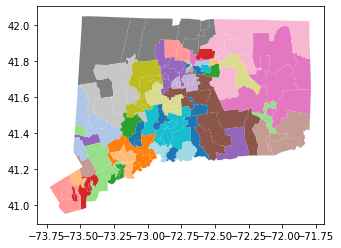

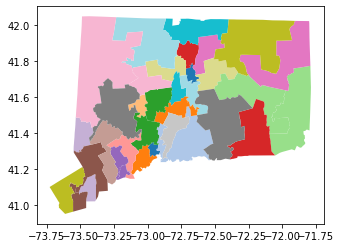

In [7]:
house_2021_df.plot(column="DISTRICT", cmap='tab20')
senate_2021_df.plot(column="DISTRICT", cmap='tab20')

## Data Cleaning

To Do:

- Clean and add incumbents in final ct_df before saving CT_analysis.shp
- Address Accuracy: Three out of 36 incumbents are not in shapefile, check that addresses are all accurate in incumbent_address
- ~Remove NaN in VAP df~
- ~Rename variables~
- ~CRS: Set VAP (block) and House and Senate (district) to the same CRS to use later with maup~

In [9]:
#Remove "not defined" under Town

ct_vap_2020_df = ct_vap_2020_df[~ct_vap_2020_df.town.str.contains("County subdivisions not defined")]
ct_vap_2020_df = ct_vap_2020_df[~ct_vap_2020_df.town.str.contains("Not in a specific geographic unit")]

In [10]:
ct_vap_2020_df.dropna(subset = ["p0030001"])

,town,geoid20,p0030001,p0030001_a,p0030001_d,geometry
0,Greenwich,090010101011000,23.0,23.0,0.0,"POLYGON ((-73.67642 41.12467, -73.66993 41.127..."
1,Greenwich,090010101011001,149.0,149.0,0.0,"POLYGON ((-73.68429 41.11007, -73.68420 41.110..."
2,Greenwich,090010101011002,12.0,13.0,1.0,"POLYGON ((-73.69362 41.10838, -73.69349 41.108..."
3,Greenwich,090010101011003,0.0,0.0,0.0,"POLYGON ((-73.68828 41.10238, -73.68821 41.102..."
4,Greenwich,090010101011004,2.0,2.0,0.0,"POLYGON ((-73.68926 41.11859, -73.68607 41.120..."
...,...,...,...,...,...,...
49921,Sterling,090159081004020,16.0,16.0,0.0,"POLYGON ((-71.84729 41.64574, -71.84694 41.645..."
49922,Sterling,090159081004021,16.0,16.0,0.0,"POLYGON ((-71.84796 41.65310, -71.84794 41.653..."
49923,Sterling,090159081004022,14.0,14.0,0.0,"POLYGON ((-71.81840 41.64453, -71.81837 41.644..."
49924,Sterling,090159081004023,0.0,0.0,0.0,"POLYGON ((-71.82013 41.64191, -71.82012 41.641..."


In [11]:
ct_vap_2020_df.town.unique()

array(['Greenwich', 'Stamford', 'Darien', 'New Canaan', 'Norwalk',
       'Wilton', 'Westport', 'Weston', 'Fairfield', 'Bridgeport',
       'Stratford', 'Trumbull', 'Monroe', 'Easton', 'Shelton', 'Bethel',
       'Brookfield', 'Danbury', 'New Fairfield', 'Newtown', 'Redding',
       'Ridgefield', 'Sherman', 'Hartland', 'Berlin', 'Bristol',
       'Burlington', 'New Britain', 'Plainville', 'Southington',
       'Farmington', 'Avon', 'Canton', 'Simsbury', 'Granby',
       'East Granby', 'Bloomfield', 'Windsor', 'Windsor Locks',
       'Suffield', 'Enfield', 'East Windsor', 'South Windsor',
       'Rocky Hill', 'Wethersfield', 'Newington', 'West Hartford',
       'Hartford', 'East Hartford', 'Manchester', 'Glastonbury',
       'Marlborough', 'Bridgewater', 'New Milford', 'North Canaan',
       'Salisbury', 'Sharon', 'Cornwall', 'Warren', 'Kent', 'Washington',
       'Roxbury', 'Barkhamsted', 'Colebrook', 'Goshen', 'Harwinton',
       'Litchfield', 'Morris', 'New Hartford', 'Torrington', '

In [12]:
ct_vap_2020_df = ct_vap_2020_df.rename(columns={"p0030001": "VAP", 
                                                "p0030001_a": "VAP_adj",
                                                "p0030001_d": "VAP_diff"})

In [13]:
ct_vap_2020_df

,town,geoid20,VAP,VAP_adj,VAP_diff,geometry
0,Greenwich,090010101011000,23.0,23.0,0.0,"POLYGON ((-73.67642 41.12467, -73.66993 41.127..."
1,Greenwich,090010101011001,149.0,149.0,0.0,"POLYGON ((-73.68429 41.11007, -73.68420 41.110..."
2,Greenwich,090010101011002,12.0,13.0,1.0,"POLYGON ((-73.69362 41.10838, -73.69349 41.108..."
3,Greenwich,090010101011003,0.0,0.0,0.0,"POLYGON ((-73.68828 41.10238, -73.68821 41.102..."
4,Greenwich,090010101011004,2.0,2.0,0.0,"POLYGON ((-73.68926 41.11859, -73.68607 41.120..."
...,...,...,...,...,...,...
49921,Sterling,090159081004020,16.0,16.0,0.0,"POLYGON ((-71.84729 41.64574, -71.84694 41.645..."
49922,Sterling,090159081004021,16.0,16.0,0.0,"POLYGON ((-71.84796 41.65310, -71.84794 41.653..."
49923,Sterling,090159081004022,14.0,14.0,0.0,"POLYGON ((-71.81840 41.64453, -71.81837 41.644..."
49924,Sterling,090159081004023,0.0,0.0,0.0,"POLYGON ((-71.82013 41.64191, -71.82012 41.641..."


In [14]:
ct_vap_2020_df.crs 

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [15]:
house_2021_df.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [16]:
senate_2021_df.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [17]:
ct_vap_2020_df = ct_vap_2020_df.to_crs(epsg=4269)

In [18]:
ct_vap_2020_df.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

## Data Merge

To Do:
- Check warnings from maup.assign
- Confirm maup assign worked as expected

In [19]:
house_assignment = maup.assign(ct_vap_2020_df, house_2021_df) #block to house district

/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:15: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometry.index = i
/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.1

/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has cha

/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has cha

/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has cha

/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has cha

/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has cha

/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has cha

/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has cha

In [20]:
senate_assignment = maup.assign(ct_vap_2020_df, senate_2021_df) #block to senate district

/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has cha

/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has cha

/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has cha

In [21]:
ct_vap_2020_df["HDIST21"] = house_assignment

In [22]:
ct_vap_2020_df["SEND21"] = senate_assignment

In [23]:
ct_vap_2020_df

,town,geoid20,VAP,VAP_adj,VAP_diff,geometry,HDIST21,SEND21
0,Greenwich,090010101011000,23.0,23.0,0.0,"POLYGON ((-73.67642 41.12467, -73.66993 41.127...",148,35
1,Greenwich,090010101011001,149.0,149.0,0.0,"POLYGON ((-73.68429 41.11007, -73.68420 41.110...",148,35
2,Greenwich,090010101011002,12.0,13.0,1.0,"POLYGON ((-73.69362 41.10838, -73.69349 41.108...",148,35
3,Greenwich,090010101011003,0.0,0.0,0.0,"POLYGON ((-73.68828 41.10238, -73.68821 41.102...",148,35
4,Greenwich,090010101011004,2.0,2.0,0.0,"POLYGON ((-73.68926 41.11859, -73.68607 41.120...",148,35
...,...,...,...,...,...,...,...,...
49921,Sterling,090159081004020,16.0,16.0,0.0,"POLYGON ((-71.84729 41.64574, -71.84694 41.645...",43,17
49922,Sterling,090159081004021,16.0,16.0,0.0,"POLYGON ((-71.84796 41.65310, -71.84794 41.653...",43,17
49923,Sterling,090159081004022,14.0,14.0,0.0,"POLYGON ((-71.81840 41.64453, -71.81837 41.644...",43,17
49924,Sterling,090159081004023,0.0,0.0,0.0,"POLYGON ((-71.82013 41.64191, -71.82012 41.641...",43,17


In [24]:
ct_df = ct_vap_2020_df

In [26]:
ct_df.to_file("./data/CT_analysis.shp")

/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Dual Graph

GerryChain uses dual graphs for analysis; this section builds dual graphs directly from the shapefile. 

To Do:
- Look into warnings

In [27]:
ct_graph = Graph.from_file("./data/CT_analysis.shp")

/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/gerrychain/graph/graph.py:238: UserWarning: Found islands (degree-0 nodes). Indices of islands: {36462}
  warnings.warn(
/Users/katherinechang/opt/miniconda3/envs/gerrych/lib/python3.10/site-packages/gerrychain/graph/graph.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


In [28]:
ct_graph.nodes[50]

{'boundary_node': False,
 'area': 2.781157499994012e-06,
 'town': 'Greenwich',
 'geoid20': '090010101014020',
 'VAP': 5.0,
 'VAP_adj': 5.0,
 'VAP_diff': 0.0,
 'HDIST21': 148,
 'SEND21': 35,
 'geometry': <shapely.geometry.polygon.Polygon at 0x17b999240>}

In [29]:
ct_df = ct_df.to_crs(epsg=4326) 

In [30]:
ct_centroids = ct_df.centroid 

#Getting warning, still runs but breaks down when mapping centroids C_X and C_Y. 
#Check which CRS to transform to

/var/folders/vp/kyx63ql12dggnl_3zsdqpsh80000gn/T/ipykernel_20639/770881599.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ct_centroids = ct_df.centroid #getting warning, still runs. Check which CRS to transform to


In [36]:
ct_df["C_X"] = ct_centroids.x
ct_df["C_Y"] = ct_centroids.y

ct_graph.add_data(ct_df,
                  columns=["C_X", "C_Y"])

In [38]:
for node in ct_graph.nodes():
    ct_graph.nodes[node]["VAP"] = int(ct_graph.nodes[node]["VAP"])
    ct_graph.nodes[node]["VAP_adj"] = int(ct_graph.nodes[node]["VAP_adj"])
    ct_graph.nodes[node]["VAP_diff"] = int(ct_graph.nodes[node]["VAP_diff"])
    ct_graph.nodes[node]["HDIST21"] = int(ct_graph.nodes[node]["HDIST21"]) 
    ct_graph.nodes[node]["SEND21"] = int(ct_graph.nodes[node]["SEND21"]) 

In [44]:
nx.draw(ct_graph,pos = {node:(ct_graph.nodes[node]['C_X'],
                              ct_graph.nodes[node]['C_Y']) 
                        for node in ct_graph.nodes()},
        node_color=[ct_graph.nodes[node]["HDIST21"] for node in ct_graph.nodes()],
        node_size=10,
        cmap='tab20')

KeyError: 'C_X'

In [ ]:
#house_2021_graph.to_json("./data/CT_analysis.json")